<center><span style="font-size:32px">Asset Growth and the Cross-Section of Stock Returns</span></center>

<center><span style="font-size:25px">Replication and Modification Exercise </span></center>




In [3]:
# Asset Growth Anomaly Analysis - Jupyter Notebook Version
# Breaking down the analysis into multiple steps for better visualization and understanding

import wrds
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from scipy import stats
import warnings
import gc
import os
warnings.filterwarnings('ignore')

# Set pandas options for better display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
#############################
# STEP 1: DATA LOADING AND INITIAL SETUP
#############################

print("# Step 1: Data Loading and Initial Setup")
print("Loading Compustat, CRSP, Linking table, and Fama-French factors...")

def load_data(download_data=False, id_wrds='user_name', start_year=1962, end_year=2024, data_folder='./data/'):
    """Load all required datasets"""
    
    if download_data:
        try:
            db = wrds.Connection(wrds_username=id_wrds)
            
            # Download Compustat
            comp = db.raw_sql(f"""
                SELECT gvkey, datadate, fyear, at, seq, ceq, txdb, pstk
                FROM comp.funda
                WHERE indfmt = 'INDL' AND datafmt = 'STD' AND popsrc = 'D' AND consol = 'C'
                AND fyear BETWEEN {start_year - 1} AND {end_year}
                AND at IS NOT NULL
            """)
            
            # Download CRSP
            crsp = db.raw_sql(f"""
                SELECT permno, date, ret, shrout, prc
                FROM crsp.msf
                WHERE date BETWEEN '01/01/{start_year - 1}' AND '12/31/{end_year}'
            """)
            
            # Download Link table
            link = db.raw_sql("""
                SELECT gvkey, lpermno AS permno, linktype, linkprim, linkdt, linkenddt
                FROM crsp.ccmxpf_linktable
                WHERE linktype IN ('LU', 'LC') AND linkprim IN ('P', 'C')
            """)
            
            db.close()
            print("✅ Data downloaded successfully from WRDS")
            
        except Exception as e:
            print(f"❌ Error downloading from WRDS: {e}")
            print("Attempting to load local data...")
            download_data = False
    
    if not download_data:
        try:
            comp = pd.read_pickle(os.path.join(data_folder, 'comp.pkl'))
            crsp = pd.read_pickle(os.path.join(data_folder, 'crsp.pkl'))
            link = pd.read_pickle(os.path.join(data_folder, 'link.pkl'))
            print("✅ Local data loaded successfully")
        except Exception as e:
            print(f"❌ Error loading local data: {e}")
            return None, None, None, None
    
    # Load Fama-French factors
    try:
        ff = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)
        print("✅ Fama-French factors loaded")
    except Exception as e:
        print(f"❌ Error loading Fama-French data: {e}")
        return comp, crsp, link, None
    
    return comp, crsp, link, ff

def display_data_overview(comp, crsp, link, ff):
    """Display overview of loaded datasets"""
    print("\n" + "="*60)
    print("DATA OVERVIEW")
    print("="*60)
    
    print(f"📊 COMPUSTAT DATA:")
    print(f"   Shape: {comp.shape}")
    print(f"   Date range: {comp['datadate'].min()} to {comp['datadate'].max()}")
    print(f"   Unique firms (gvkey): {comp['gvkey'].nunique():,}")
    print(f"   Sample of data:")
    display(comp.head())
    
    print(f"\n📈 CRSP DATA:")
    print(f"   Shape: {crsp.shape}")
    print(f"   Date range: {crsp['date'].min()} to {crsp['date'].max()}")
    print(f"   Unique firms (permno): {crsp['permno'].nunique():,}")
    print(f"   Sample of data:")
    display(crsp.head())
    
    print(f"\n🔗 LINK TABLE:")
    print(f"   Shape: {link.shape}")
    print(f"   Sample of data:")
    display(link.head())
    
    if ff is not None:
        print(f"\n📊 FAMA-FRENCH FACTORS:")
        print(f"   Shape: {ff.shape}")
        print(f"   Sample of data:")
        display(ff.head())

# Execute Step 1
comp, crsp, link, ff = load_data(download_data=False)  # Set to True if you have WRDS access
if comp is not None:
    display_data_overview(comp, crsp, link, ff)

# Step 1: Data Loading and Initial Setup
Loading Compustat, CRSP, Linking table, and Fama-French factors...
✅ Local data loaded successfully
✅ Fama-French factors loaded

DATA OVERVIEW
📊 COMPUSTAT DATA:
   Shape: (474622, 8)
   Date range: 1961-06-30 to 2024-05-31
   Unique firms (gvkey): 36,828
   Sample of data:


,gvkey,datadate,fyear,at,seq,ceq,txdb,pstk
0,001000,1964-12-31,1964,1.416,0.607,0.607,0.02,0.0
1,001000,1965-12-31,1965,2.31,0.491,0.491,0.0,0.0
2,001000,1966-12-31,1966,2.43,0.834,0.834,0.0,0.0
3,001000,1967-12-31,1967,2.456,0.744,0.744,0.0,0.0
4,001000,1968-12-31,1968,5.922,2.571,2.571,0.0,0.0



📈 CRSP DATA:
   Shape: (4673823, 5)
   Date range: 1961-01-31 to 2023-12-29
   Unique firms (permno): 37,359
   Sample of data:


,permno,date,ret,shrout,prc
0,10000,1985-12-31,<NA>,<NA>,<NA>
1,10000,1986-01-31,<NA>,3680.0,-4.375
2,10000,1986-02-28,-0.257143,3680.0,-3.25
3,10000,1986-03-31,0.365385,3680.0,-4.4375
4,10000,1986-04-30,-0.098592,3793.0,-4.0



🔗 LINK TABLE:
   Shape: (32849, 6)
   Sample of data:


,gvkey,permno,linktype,linkprim,linkdt,linkenddt
0,001000,25881.0,LU,P,1970-11-13,1978-06-30
1,001001,10015.0,LU,P,1983-09-20,1986-07-31
2,001002,10023.0,LC,C,1972-12-14,1973-06-05
3,001003,10031.0,LU,C,1983-12-07,1989-08-16
4,001004,54594.0,LU,P,1972-04-24,<NA>



📊 FAMA-FRENCH FACTORS:
   Shape: (1283, 5)
   Sample of data:


,Unnamed: 0,Mkt-RF,SMB,HML,RF
0,192607,2.96,-2.56,-2.43,0.22
1,192608,2.64,-1.17,3.82,0.25
2,192609,0.36,-1.40,0.13,0.23
3,192610,-3.24,-0.09,0.70,0.32
4,192611,2.53,-0.10,-0.51,0.31


In [5]:
#############################
# STEP 2: DATA CLEANING AND PREPROCESSING
#############################

print("\n" + "="*60)
print("# Step 2: Data Cleaning and Preprocessing")
print("Applying filters and optimizing data for analysis...")

def clean_data(comp, crsp):
    """Enhanced data cleaning with memory optimization"""
    
    # Compustat filters
    initial_comp = len(comp)
    comp = comp[comp['at'].notna()]
    comp = comp[comp['at'] >= 1]  # Minimum asset size
    comp = comp[comp['fyear'].notna()]
    comp = comp[comp['datadate'].notna()]
    
    print(f"📊 COMPUSTAT CLEANING:")
    print(f"   Initial observations: {initial_comp:,}")
    print(f"   After cleaning: {len(comp):,}")
    print(f"   Removed: {initial_comp - len(comp):,} ({(initial_comp - len(comp))/initial_comp*100:.1f}%)")
    
    # CRSP filters
    initial_crsp = len(crsp)
    crsp = crsp[crsp['ret'].notna()]
    crsp = crsp[crsp['shrout'] > 0]
    crsp = crsp[crsp['prc'].abs() >= 1]  # Remove penny stocks
    crsp = crsp[crsp['ret'].between(-0.5, 2.0)]  # Remove extreme returns
    
    print(f"\n📈 CRSP CLEANING:")
    print(f"   Initial observations: {initial_crsp:,}")
    print(f"   After cleaning: {len(crsp):,}")
    print(f"   Removed: {initial_crsp - len(crsp):,} ({(initial_crsp - len(crsp))/initial_crsp*100:.1f}%)")
    
    # Optimize data types
    if 'permno' in crsp.columns:
        crsp['permno'] = crsp['permno'].astype('int32')
    if 'ret' in crsp.columns:
        crsp['ret'] = crsp['ret'].astype('float32')
    if 'prc' in crsp.columns:
        crsp['prc'] = crsp['prc'].astype('float32')
    if 'shrout' in crsp.columns:
        crsp['shrout'] = crsp['shrout'].astype('float32')
    
    if 'gvkey' in comp.columns:
        comp['gvkey'] = comp['gvkey'].astype('str')
    if 'at' in comp.columns:
        comp['at'] = comp['at'].astype('float32')
    if 'fyear' in comp.columns:
        comp['fyear'] = comp['fyear'].astype('int16')
    
    print(f"\n✅ Data types optimized for memory efficiency")
    print(f"📊 Final Compustat shape: {comp.shape}")
    print(f"📈 Final CRSP shape: {crsp.shape}")
    
    return comp, crsp

# Execute Step 2
if comp is not None:
    comp_clean, crsp_clean = clean_data(comp, crsp)


# Step 2: Data Cleaning and Preprocessing
Applying filters and optimizing data for analysis...
📊 COMPUSTAT CLEANING:
   Initial observations: 474,622
   After cleaning: 454,830
   Removed: 19,792 (4.2%)

📈 CRSP CLEANING:
   Initial observations: 4,673,823
   After cleaning: 4,273,282
   Removed: 400,541 (8.6%)

✅ Data types optimized for memory efficiency
📊 Final Compustat shape: (454830, 8)
📈 Final CRSP shape: (4273282, 5)


In [6]:
#############################
# STEP 3: ASSET GROWTH SIGNAL CONSTRUCTION
#############################

print("\n" + "="*60)
print("# Step 3: Asset Growth Signal Construction")
print("Computing asset growth signal and creating portfolios...")

def compute_asset_growth(comp, crsp, link):
    """Compute asset growth signal and merge with return data"""
    
    print("🔄 Processing Compustat data...")
    comp = comp.copy()
    comp['datadate'] = pd.to_datetime(comp['datadate'])
    comp = comp.sort_values(['gvkey', 'datadate'])
    
    print("🔄 Processing CRSP data...")
    crsp = crsp.copy()
    crsp['date'] = pd.to_datetime(crsp['date'])
    crsp['mktcap'] = crsp['prc'].abs() * crsp['shrout'] / 1000
    
    print("🔄 Cleaning link data...")
    link = link.dropna(subset=['permno'])
    link['linkdt'] = pd.to_datetime(link['linkdt'])
    link['linkenddt'] = pd.to_datetime(link['linkenddt']).fillna(datetime(2025, 1, 1))
    
    print("📊 Calculating asset growth...")
    comp['at_lag_1'] = comp.groupby('gvkey')['at'].shift(1)
    comp['at_lag_2'] = comp.groupby('gvkey')['at'].shift(2)
    comp = comp[(comp['at'] > 0) & (comp['at_lag_1'] > 0) & (comp['at_lag_2'] > 0)].copy()
    comp['asset_growth'] = (comp['at_lag_1'] - comp['at_lag_2']) / comp['at_lag_2']
    
    # Winsorize asset growth
    comp['asset_growth'] = winsorize(comp['asset_growth'].astype('float64'), limits=[0.01, 0.01])
    
    # Add year for grouping
    comp['year'] = comp['datadate'].dt.year
    
    # Filter to June observations
    comp_june = comp[comp['datadate'].dt.month == 6].copy()
    
    print(f"📊 Asset growth statistics:")
    print(comp_june['asset_growth'].describe())
    
    print(f"\n📊 Asset growth by percentiles:")
    percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    ag_percentiles = comp_june['asset_growth'].quantile([p/100 for p in percentiles])
    for p, val in zip(percentiles, ag_percentiles):
        print(f"   {p}th percentile: {val:.4f}")
    
    # Assign deciles
    comp_june['decile'] = comp_june.groupby('year')['asset_growth'].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
    )
    
    print(f"\n📊 Decile assignment summary:")
    decile_summary = comp_june.groupby('decile')['asset_growth'].agg(['count', 'mean', 'min', 'max'])
    display(decile_summary)
    
    # Merge with link table
    print("🔗 Merging with link table...")
    comp_linked = pd.merge(comp_june, link, on='gvkey', how='inner')
    comp_linked = comp_linked[(comp_linked['datadate'] >= comp_linked['linkdt']) & 
                              (comp_linked['datadate'] <= comp_linked['linkenddt'])]
    
    # Prepare CRSP data with year adjustment for July-June alignment
    crsp['year'] = crsp['date'].dt.year
    crsp['month'] = crsp['date'].dt.month
    crsp_lag = crsp.copy()
    crsp_lag['year'] = crsp_lag['year'] - (crsp_lag['month'] < 7)
    
    # Merge Compustat and CRSP
    print("🔗 Merging Compustat and CRSP...")
    merged = pd.merge(comp_linked, crsp_lag, on=['permno', 'year'], how='inner')
    
    # Re-assign deciles after merging
    merged['decile'] = merged.groupby('year')['asset_growth'].transform(
        lambda x: pd.qcut(x, 10, labels=False, duplicates='drop') + 1
    )
    
    print(f"\n✅ Final merged dataset:")
    print(f"   Shape: {merged.shape}")
    print(f"   Time period: {merged['date'].min().strftime('%Y-%m')} to {merged['date'].max().strftime('%Y-%m')}")
    print(f"   Unique firms: {merged['permno'].nunique():,}")
    print(f"   Firm-month observations: {len(merged):,}")
    
    return merged

def display_portfolio_characteristics(merged):
    """Display characteristics of asset growth portfolios"""
    print("\n" + "="*50)
    print("PORTFOLIO CHARACTERISTICS")
    print("="*50)
    
    # Portfolio size and asset growth by decile
    portfolio_chars = merged.groupby('decile').agg({
        'permno': 'nunique',
        'asset_growth': ['mean', 'median', 'std'],
        'mktcap': ['mean', 'median'],
        'date': 'count'
    }).round(4)
    
    portfolio_chars.columns = ['Unique_Firms', 'AG_Mean', 'AG_Median', 'AG_Std', 
                              'MktCap_Mean', 'MktCap_Median', 'Observations']
    
    print("Portfolio characteristics by Asset Growth decile:")
    display(portfolio_chars)
    
    # Time series coverage
    coverage = merged.groupby('year').agg({
        'permno': 'nunique',
        'gvkey': 'nunique', 
        'asset_growth': lambda x: x.notna().sum()
    }).reset_index()
    
    coverage.columns = ['Year', 'Unique_PERMNOs', 'Unique_GVKEYs', 'Valid_AssetGrowth']
    
    print(f"\n📊 Sample coverage over time:")
    print(f"   First 10 years:")
    display(coverage.head(10))
    print(f"   Last 10 years:")
    display(coverage.tail(10))
    
    print(f"\n📊 Coverage summary:")
    print(f"   Total unique firms: {merged['permno'].nunique():,}")
    print(f"   Average firms per year: {coverage['Unique_PERMNOs'].mean():.0f}")
    print(f"   Years with data: {coverage['Year'].min()} to {coverage['Year'].max()}")

# Execute Step 3
if comp is not None:
    merged = compute_asset_growth(comp_clean, crsp_clean, link)
    display_portfolio_characteristics(merged)


# Step 3: Asset Growth Signal Construction
Computing asset growth signal and creating portfolios...
🔄 Processing Compustat data...
🔄 Processing CRSP data...
🔄 Cleaning link data...
📊 Calculating asset growth...
📊 Asset growth statistics:
count    26702.000000
mean         0.207913
std          0.616654
min         -0.578332
25%         -0.040957
50%          0.071707
75%          0.239071
max          4.215117
Name: asset_growth, dtype: float64

📊 Asset growth by percentiles:
   1th percentile: -0.5783
   5th percentile: -0.3168
   10th percentile: -0.1907
   25th percentile: -0.0410
   50th percentile: 0.0717
   75th percentile: 0.2391
   90th percentile: 0.6228
   95th percentile: 1.1387
   99th percentile: 3.7536

📊 Decile assignment summary:


,count,mean,min,max
decile,,,,
1,2698,-0.329505,-0.578332,-0.006711
2,2671,-0.118821,-0.358374,0.049654
3,2654,-0.041473,-0.234949,0.093591
4,2671,0.008925,-0.151700,0.128577
5,2675,0.051555,-0.081727,0.185306
6,2652,0.096865,-0.039100,0.267862
7,2666,0.155567,0.001240,0.385170
8,2659,0.247994,0.046348,0.612919
9,2665,0.452442,0.092513,1.606524


🔗 Merging with link table...
🔗 Merging Compustat and CRSP...

✅ Final merged dataset:
   Shape: (214788, 24)
   Time period: 1963-07 to 2023-12
   Unique firms: 2,037
   Firm-month observations: 214,788

PORTFOLIO CHARACTERISTICS
Portfolio characteristics by Asset Growth decile:


,Unique_Firms,AG_Mean,AG_Median,AG_Std,MktCap_Mean,MktCap_Median,Observations
decile,,,,,,,
1,937,-0.2416,-0.2130,0.1366,536.385681,25.486099,21834
2,929,-0.0686,-0.0656,0.0555,1334.197510,38.709000,21491
3,858,-0.0074,-0.0056,0.0444,1490.333252,52.217499,21462
4,843,0.0353,0.0366,0.0410,1603.233887,64.819199,21417
5,850,0.0745,0.0762,0.0421,4283.130859,73.953796,21511
6,887,0.1188,0.1219,0.0473,1549.999634,80.592003,21509
7,900,0.1768,0.1804,0.0613,3944.201904,80.727303,21483
8,947,0.2678,0.2615,0.0924,3056.215088,86.397400,21435
9,1026,0.4682,0.4359,0.1930,2426.552002,77.121002,21485



📊 Sample coverage over time:
   First 10 years:


,Year,Unique_PERMNOs,Unique_GVKEYs,Valid_AssetGrowth
0,1963,73,73,862
1,1964,83,83,995
2,1965,99,99,1180
3,1966,108,108,1294
4,1967,115,115,1379
5,1968,134,134,1608
6,1969,151,151,1810
7,1970,157,157,1851
8,1971,166,166,1975
9,1972,174,174,2069


   Last 10 years:


,Year,Unique_PERMNOs,Unique_GVKEYs,Valid_AssetGrowth
51,2014,233,233,2558
52,2015,218,218,2383
53,2016,212,212,2439
54,2017,203,203,2297
55,2018,192,192,2158
56,2019,188,188,2079
57,2020,190,190,2189
58,2021,197,197,2206
59,2022,206,206,2209
60,2023,200,200,1110



📊 Coverage summary:
   Total unique firms: 2,037
   Average firms per year: 315
   Years with data: 1963 to 2023


In [7]:
#############################
# STEP 4: MONTHLY RETURNS CALCULATION
#############################

print("\n" + "="*60)
print("# Step 4: Monthly Returns Calculation")
print("Computing value-weighted returns and preparing Fama-French factors...")

def compute_monthly_returns(merged, ff):
    """Compute monthly value-weighted returns by decile"""
    
    # Clean Fama-French data
    ff = ff[ff['Unnamed: 0'].astype(str).str.match(r'^\d{6}$')].copy()
    ff = ff.rename(columns={'Unnamed: 0': 'date'})
    ff['date'] = pd.to_datetime(ff['date'], format='%Y%m')
    ff = ff[['date', 'Mkt-RF', 'SMB', 'HML', 'RF']].dropna()
    
    for col in ['Mkt-RF', 'SMB', 'HML', 'RF']:
        ff[col] = pd.to_numeric(ff[col], errors='coerce') / 100
    
    print(f"📊 Fama-French factors:")
    print(f"   Date range: {ff['date'].min().strftime('%Y-%m')} to {ff['date'].max().strftime('%Y-%m')}")
    print(f"   Sample:")
    display(ff.head())
    
    # Prepare merged data
    merged['month'] = merged['date'].dt.month
    merged['ff_date'] = merged['date'].dt.to_period('M').dt.to_timestamp()
    
    # Calculate VW monthly returns by decile
    def weighted_ret(group):
        valid = group[['ret', 'mktcap']].dropna()
        if len(valid) == 0:
            return np.nan
        return np.average(valid['ret'], weights=valid['mktcap'])
    
    print("📊 Computing value-weighted returns by decile...")
    monthly_vw = merged.groupby(['ff_date', 'decile']).apply(weighted_ret).reset_index(name='vw_ret')
    monthly_vw = monthly_vw.merge(ff, left_on='ff_date', right_on='date', how='inner')
    monthly_vw['excess_ret'] = monthly_vw['vw_ret'] - monthly_vw['RF']
    
    print(f"✅ Monthly returns computed:")
    print(f"   Total observations: {len(monthly_vw):,}")
    print(f"   Date range: {monthly_vw['ff_date'].min().strftime('%Y-%m')} to {monthly_vw['ff_date'].max().strftime('%Y-%m')}")
    print(f"   Deciles: {sorted(monthly_vw['decile'].unique())}")
    
    # Display monthly returns summary
    monthly_summary = monthly_vw.groupby('decile')['excess_ret'].agg(['count', 'mean', 'std']).round(4)
    monthly_summary.columns = ['Observations', 'Mean_Monthly_Return', 'Std_Monthly_Return']
    monthly_summary['Annualized_Return'] = monthly_summary['Mean_Monthly_Return'] * 12
    monthly_summary['Annualized_Volatility'] = monthly_summary['Std_Monthly_Return'] * np.sqrt(12)
    
    print(f"\n📊 Monthly returns summary by decile:")
    display(monthly_summary)
    
    return monthly_vw

# Execute Step 4
if 'merged' in locals() and ff is not None:
    monthly_vw = compute_monthly_returns(merged, ff)


# Step 4: Monthly Returns Calculation
Computing value-weighted returns and preparing Fama-French factors...
📊 Fama-French factors:
   Date range: 1926-07 to 2024-12
   Sample:


,date,Mkt-RF,SMB,HML,RF
0,1926-07-01,0.0296,-0.0256,-0.0243,0.0022
1,1926-08-01,0.0264,-0.0117,0.0382,0.0025
2,1926-09-01,0.0036,-0.0140,0.0013,0.0023
3,1926-10-01,-0.0324,-0.0009,0.0070,0.0032
4,1926-11-01,0.0253,-0.0010,-0.0051,0.0031


📊 Computing value-weighted returns by decile...
✅ Monthly returns computed:
   Total observations: 7,260
   Date range: 1963-07 to 2023-12
   Deciles: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

📊 Monthly returns summary by decile:


,Observations,Mean_Monthly_Return,Std_Monthly_Return,Annualized_Return,Annualized_Volatility
decile,,,,,
1,726,0.0286,0.0935,0.3432,0.323894
2,726,0.0182,0.0772,0.2184,0.267429
3,726,0.0141,0.0587,0.1692,0.203343
4,726,0.0134,0.0563,0.1608,0.195029
5,726,0.0111,0.0568,0.1332,0.196761
6,726,0.0125,0.0607,0.1500,0.210271
7,726,0.0149,0.0649,0.1788,0.224820
8,726,0.0153,0.0755,0.1836,0.261540
9,726,0.0127,0.0779,0.1524,0.269854


In [8]:
#############################
# STEP 5: FAMA-FRENCH 3-FACTOR ANALYSIS
#############################

print("\n" + "="*60)
print("# Step 5: Fama-French 3-Factor Analysis")
print("Running factor regressions for each decile...")

def ff3_factor_analysis(monthly_vw):
    """Run Fama-French 3-factor regressions for each decile"""
    
    decile_results = []
    
    print("🔄 Running regressions for each decile...")
    for decile in sorted(monthly_vw['decile'].dropna().unique()):
        sub = monthly_vw[monthly_vw['decile'] == decile].copy()
        if len(sub) < 24:  # Require at least 2 years of data
            continue
            
        X = sub[['Mkt-RF', 'SMB', 'HML']].dropna()
        X = sm.add_constant(X)
        y = sub['excess_ret'].reindex(X.index)
        
        if len(X) < 12:  # Skip if insufficient data
            continue
            
        model = sm.OLS(y, X).fit()
        alpha = model.params['const']
        t_alpha = model.tvalues['const']
        r_squared = model.rsquared
        
        decile_results.append({
            'Decile': decile, 
            'Alpha_Monthly': alpha, 
            'Alpha_Annual': alpha * 12,
            't_Alpha': t_alpha,
            'R_squared': r_squared,
            'Beta': model.params.get('Mkt-RF', np.nan),
            'SMB': model.params.get('SMB', np.nan),
            'HML': model.params.get('HML', np.nan),
            'Observations': len(X),
            'Std_Error': model.bse['const'],
            'P_Value': model.pvalues['const']
        })
    
    ff_results = pd.DataFrame(decile_results).sort_values('Decile')
    
    print("✅ Fama-French 3-Factor Results:")
    display_cols = ['Decile', 'Alpha_Monthly', 't_Alpha', 'Beta', 'SMB', 'HML', 'R_squared']
    display(ff_results[display_cols].round(4))
    
    print(f"\n📊 Detailed Results:")
    display(ff_results.round(4))
    
    return ff_results

# Execute Step 5
if 'monthly_vw' in locals():
    ff_results = ff3_factor_analysis(monthly_vw)



# Step 5: Fama-French 3-Factor Analysis
Running factor regressions for each decile...
🔄 Running regressions for each decile...
✅ Fama-French 3-Factor Results:


,Decile,Alpha_Monthly,t_Alpha,Beta,SMB,HML,R_squared
0,1,0.0209,8.6509,1.0828,1.1050,-0.1541,0.5317
1,2,0.0124,5.5020,0.9705,0.3432,-0.1175,0.3986
2,3,0.0078,5.2291,0.9400,0.2120,0.2199,0.5530
3,4,0.0076,5.5204,0.8968,0.2412,0.0621,0.5766
4,5,0.0054,4.1526,0.9676,0.1460,-0.0293,0.6348
5,6,0.0067,4.4967,0.9824,0.1915,-0.0284,0.5847
6,7,0.0099,6.6798,1.0173,0.2258,-0.3798,0.6391
7,8,0.0089,5.0292,1.1707,0.3341,-0.2985,0.6128
8,9,0.0067,3.6876,1.1836,0.3248,-0.4557,0.6212
9,10,0.0103,4.7262,1.2752,0.5962,-0.5681,0.6010



📊 Detailed Results:


,Decile,Alpha_Monthly,Alpha_Annual,t_Alpha,R_squared,Beta,SMB,HML,Observations,Std_Error,P_Value
0,1,0.0209,0.2510,8.6509,0.5317,1.0828,1.1050,-0.1541,726,0.0024,0.0000
1,2,0.0124,0.1493,5.5020,0.3986,0.9705,0.3432,-0.1175,726,0.0023,0.0000
2,3,0.0078,0.0932,5.2291,0.5530,0.9400,0.2120,0.2199,726,0.0015,0.0000
3,4,0.0076,0.0917,5.5204,0.5766,0.8968,0.2412,0.0621,726,0.0014,0.0000
4,5,0.0054,0.0646,4.1526,0.6348,0.9676,0.1460,-0.0293,726,0.0013,0.0000
5,6,0.0067,0.0798,4.4967,0.5847,0.9824,0.1915,-0.0284,726,0.0015,0.0000
6,7,0.0099,0.1182,6.6798,0.6391,1.0173,0.2258,-0.3798,726,0.0015,0.0000
7,8,0.0089,0.1072,5.0292,0.6128,1.1707,0.3341,-0.2985,726,0.0018,0.0000
8,9,0.0067,0.0802,3.6876,0.6212,1.1836,0.3248,-0.4557,726,0.0018,0.0002
9,10,0.0103,0.1239,4.7262,0.6010,1.2752,0.5962,-0.5681,726,0.0022,0.0000


In [9]:
#############################
# STEP 6: STRATEGY COMPARISON
#############################

print("\n" + "="*60)
print("# Step 6: Long-Short Strategy Comparison")
print("Comparing different shorting strategies...")

def compare_strategies(monthly_vw, ff_results, long_decile=1, short_deciles=[5, 10]):
    """Compare long-short strategies with different short legs"""
    
    strategies = []
    
    for short_decile in short_deciles:
        if long_decile in ff_results['Decile'].values and short_decile in ff_results['Decile'].values:
            
            # Create strategy time series
            long_data = monthly_vw[monthly_vw['decile'] == long_decile].set_index('ff_date')
            short_data = monthly_vw[monthly_vw['decile'] == short_decile].set_index('ff_date')
            
            strategy_data = pd.merge(long_data[['excess_ret', 'Mkt-RF', 'SMB', 'HML']], 
                                   short_data[['excess_ret']], 
                                   left_index=True, right_index=True, 
                                   suffixes=('_long', '_short'))
            strategy_data['long_short_ret'] = strategy_data['excess_ret_long'] - strategy_data['excess_ret_short']
            
            # Run FF3 regression on strategy
            X_strategy = strategy_data[['Mkt-RF', 'SMB', 'HML']].dropna()
            X_strategy = sm.add_constant(X_strategy)
            y_strategy = strategy_data['long_short_ret'].reindex(X_strategy.index)
            
            strategy_model = sm.OLS(y_strategy, X_strategy).fit()
            
            strategy_info = {
                'Strategy': f'Long {long_decile} / Short {short_decile}',
                'Long_Decile': long_decile,
                'Short_Decile': short_decile,
                'Monthly_Alpha': strategy_model.params['const'],
                'Annual_Alpha': strategy_model.params['const'] * 12,
                't_Alpha': strategy_model.tvalues['const'],
                'P_Value': strategy_model.pvalues['const'],
                'Beta': strategy_model.params.get('Mkt-RF', np.nan),
                'SMB': strategy_model.params.get('SMB', np.nan),
                'HML': strategy_model.params.get('HML', np.nan),
                'R_squared': strategy_model.rsquared,
                'Observations': len(X_strategy),
                'Strategy_Data': strategy_data
            }
            
            strategies.append(strategy_info)
            
            print(f"📊 STRATEGY: Long {long_decile} / Short {short_decile}")
            print(f"   Monthly Alpha: {strategy_model.params['const']:.4%}")
            print(f"   Annualized Alpha: {strategy_model.params['const']*12:.2%}")
            print(f"   t-statistic: {strategy_model.tvalues['const']:.2f}")
            print(f"   P-value: {strategy_model.pvalues['const']:.4f}")
            print(f"   R-squared: {strategy_model.rsquared:.3f}")
    
    # Compare strategies
    if len(strategies) >= 2:
        print(f"\n🚀 STRATEGY COMPARISON:")
        strategy_df = pd.DataFrame([{k: v for k, v in s.items() if k != 'Strategy_Data'} for s in strategies])
        display(strategy_df.round(4))
        
        alpha_diff = strategies[0]['Monthly_Alpha'] - strategies[1]['Monthly_Alpha']
        t_stat_diff = abs(strategies[0]['t_Alpha']) - abs(strategies[1]['t_Alpha'])
        
        print(f"\n📈 Performance Difference:")
        print(f"   Alpha Difference: {alpha_diff:.4%} per month ({alpha_diff*12:.2%} annually)")
        print(f"   t-statistic Difference: {t_stat_diff:.2f}")
        
        if alpha_diff > 0:
            print(f"✅ Strategy 1 (Short {short_deciles[0]}) outperforms Strategy 2 (Short {short_deciles[1]})")
        else:
            print(f"✅ Strategy 2 (Short {short_deciles[1]}) outperforms Strategy 1 (Short {short_deciles[0]})")
    
    return strategies

# Execute Step 6
if 'monthly_vw' in locals() and 'ff_results' in locals():
    strategies = compare_strategies(monthly_vw, ff_results, long_decile=1, short_deciles=[5, 10])


# Step 6: Long-Short Strategy Comparison
Comparing different shorting strategies...
📊 STRATEGY: Long 1 / Short 5
   Monthly Alpha: 1.5530%
   Annualized Alpha: 18.64%
   t-statistic: 5.60
   P-value: 0.0000
   R-squared: 0.160
📊 STRATEGY: Long 1 / Short 10
   Monthly Alpha: 1.0595%
   Annualized Alpha: 12.71%
   t-statistic: 3.38
   P-value: 0.0008
   R-squared: 0.051

🚀 STRATEGY COMPARISON:


,Strategy,Long_Decile,Short_Decile,Monthly_Alpha,Annual_Alpha,t_Alpha,P_Value,Beta,SMB,HML,R_squared,Observations
0,Long 1 / Short 5,1,5,0.0155,0.1864,5.6002,0.0000,0.1152,0.9590,-0.1248,0.1605,726
1,Long 1 / Short 10,1,10,0.0106,0.1271,3.3796,0.0008,-0.1924,0.5088,0.4140,0.0513,726



📈 Performance Difference:
   Alpha Difference: 0.4935% per month (5.92% annually)
   t-statistic Difference: 2.22
✅ Strategy 1 (Short 5) outperforms Strategy 2 (Short 10)


In [10]:
#############################
# STEP 7: PERFORMANCE METRICS CALCULATION
#############################

print("\n" + "="*60)
print("# Step 7: Comprehensive Performance Metrics")
print("Calculating detailed performance statistics...")

def calculate_performance_metrics(returns_series, strategy_name=""):
    """Calculate comprehensive performance metrics"""
    
    if len(returns_series.dropna()) == 0:
        return {}
    
    returns = returns_series.dropna()
    
    # Basic performance metrics
    total_return = (1 + returns).prod() - 1
    ann_ret = (1 + returns).prod() ** (12 / len(returns)) - 1  
    ann_vol = returns.std() * np.sqrt(12)                     
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    
    # Risk metrics
    var_5 = np.percentile(returns, 5)
    cvar_5 = returns[returns <= var_5].mean() if np.sum(returns <= var_5) > 0 else np.nan
    skewness = returns.skew()
    kurtosis = returns.kurtosis()
    
    # Downside metrics
    downside_returns = returns[returns < 0]
    downside_vol = downside_returns.std() * np.sqrt(12) if len(downside_returns) > 0 else 0
    sortino = ann_ret / downside_vol if downside_vol != 0 else np.nan
    
    # Drawdown analysis
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_dd = drawdown.min()
    
    # Additional metrics
    win_rate = (returns > 0).mean()
    avg_win = returns[returns > 0].mean() if np.sum(returns > 0) > 0 else 0
    avg_loss = returns[returns < 0].mean() if np.sum(returns < 0) > 0 else 0
    win_loss_ratio = abs(avg_win / avg_loss) if avg_loss != 0 else np.nan
    
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else np.nan
    
    metrics = {
        "Strategy": strategy_name,
        "Annualized_Return": ann_ret * 100,
        "Annualized_Volatility": ann_vol * 100,
        "Sharpe_Ratio": sharpe,
        "Sortino_Ratio": sortino,
        "Calmar_Ratio": calmar,
        "Maximum_Drawdown": max_dd * 100,
        "VaR_5pct": var_5 * 100,
        "CVaR_5pct": cvar_5 * 100,
        "Skewness": skewness,
        "Kurtosis": kurtosis,
        "Win_Rate": win_rate * 100,
        "Win_Loss_Ratio": win_loss_ratio,
        "Number_of_Months": len(returns)
    }
    
    return metrics

def compare_strategy_performance(strategies):
    """Compare performance across strategies"""
    
    performance_comparison = []
    
    for strategy in strategies:
        if 'Strategy_Data' in strategy:
            returns = strategy['Strategy_Data']['long_short_ret']
            strategy_name = strategy['Strategy']
            
            metrics = calculate_performance_metrics(returns, strategy_name)
            performance_comparison.append(metrics)
    
    comparison_df = pd.DataFrame(performance_comparison)
    
    print("📊 Comprehensive Performance Comparison:")
    display(comparison_df.round(3))
    
    return comparison_df

# Execute Step 7
if 'strategies' in locals():
    performance_comparison = compare_strategy_performance(strategies)


# Step 7: Comprehensive Performance Metrics
Calculating detailed performance statistics...
📊 Comprehensive Performance Comparison:


,Strategy,Annualized_Return,Annualized_Volatility,Sharpe_Ratio,Sortino_Ratio,Calmar_Ratio,Maximum_Drawdown,VaR_5pct,CVaR_5pct,Skewness,Kurtosis,Win_Rate,Win_Loss_Ratio,Number_of_Months
0,Long 1 / Short 5,18.936,27.734,0.683,1.406,0.421,-45.014,-8.45,-12.618,1.305,4.685,54.821,1.578,726
1,Long 1 / Short 10,10.143,29.493,0.344,0.576,0.132,-76.898,-11.36,-16.618,0.462,2.437,56.474,1.120,726


In [12]:
#############################
# STEP 7.5: FAMA-MACBETH CROSS-SECTIONAL ANALYSIS
#############################

print("\n" + "="*60)
print("# Step 7.5: Fama-MacBeth Cross-Sectional Analysis")
print("Running monthly cross-sectional regressions to test asset growth at individual stock level...")

def fama_macbeth(merged):
    """
    Fama-MacBeth cross-sectional regressions
    Tests whether asset growth predicts individual stock returns
    """
    print("🔄 Running Fama-MacBeth cross-sectional regressions...")
    
    if len(merged) == 0:
        print("❌ No data available for Fama-MacBeth analysis")
        return None
    
    print("📊 Preparing variables for cross-sectional analysis...")
    
    # Prep monthly panel with predictors (t) and next-month return (t+1)
    merged_fm = merged.sort_values(['permno', 'date']).copy()
    merged_fm['ret_t1'] = merged_fm.groupby('permno')['ret'].shift(-1)  # Next month return
    
    # Create control variables
    merged_fm['log_mktcap'] = np.log(merged_fm['mktcap'])
    
    # Book-to-market (if book equity data available)
    if 'ceq' in merged_fm.columns:
        merged_fm['bm'] = merged_fm['ceq'] / (merged_fm['mktcap'] * 1000)
        merged_fm['bm'] = merged_fm['bm'].replace([np.inf, -np.inf], np.nan)
    else:
        merged_fm['bm'] = np.nan
    
    # Momentum: 11-month cumulative return (skipping most recent month)
    merged_fm['ret_lag'] = merged_fm.groupby('permno')['ret'].shift(1)
    merged_fm['momentum_11m'] = merged_fm.groupby('permno')['ret_lag'].transform(
        lambda x: x.rolling(window=11, min_periods=6).apply(
            lambda y: (1 + y).prod() - 1 if len(y) >= 6 else np.nan, raw=False
        )
    )
    
    # Select variables for regression
    base_vars = ['date', 'permno', 'ret_t1', 'asset_growth', 'log_mktcap']
    optional_vars = ['bm', 'momentum_11m']
    
    # Check which variables are available and have sufficient data
    regression_vars = base_vars.copy()
    for var in optional_vars:
        if var in merged_fm.columns and merged_fm[var].notna().sum() > len(merged_fm) * 0.1:
            regression_vars.append(var)
    
    print(f"📋 Variables for cross-sectional regressions: {regression_vars}")
    
    # Clean data for regression
    merged_clean = merged_fm[regression_vars].dropna()
    
    if len(merged_clean) == 0:
        print("❌ No valid observations after cleaning for Fama-MacBeth regression")
        return None
    
    print(f"✅ Sample for Fama-MacBeth: {len(merged_clean):,} observations")
    print(f"📅 Date range: {merged_clean['date'].min().strftime('%Y-%m')} to {merged_clean['date'].max().strftime('%Y-%m')}")
    
    # Winsorize variables at 1% and 99% to reduce outlier influence
    winsorize_vars = [var for var in regression_vars if var not in ['date', 'permno', 'ret_t1']]
    for var in winsorize_vars:
        if var in merged_clean.columns:
            merged_clean[var] = winsorize(merged_clean[var].astype(float), limits=[0.01, 0.01])
    
    # Run cross-sectional regressions month by month
    print("🔄 Running monthly cross-sectional regressions...")
    coefficients = []
    predictor_vars = [var for var in winsorize_vars if var in merged_clean.columns]
    
    monthly_count = 0
    for date, group in merged_clean.groupby('date'):
        if len(group) < 30:  # Require at least 30 stocks per month
            continue
            
        # Prepare regression
        X = group[predictor_vars].copy()
        X = sm.add_constant(X)
        y = group['ret_t1']
        
        try:
            # Run OLS regression
            model = sm.OLS(y.astype(float), X.astype(float)).fit()
            
            # Store coefficients
            coef_dict = model.params.to_dict()
            coef_dict['date'] = date
            coef_dict['n_stocks'] = len(group)
            coef_dict['r_squared'] = model.rsquared
            coefficients.append(coef_dict)
            monthly_count += 1
            
        except Exception as e:
            continue
    
    if len(coefficients) == 0:
        print("❌ No successful cross-sectional regressions")
        return None
    
    print(f"✅ Successfully ran {monthly_count} monthly regressions")
    
    # Analyze time-series of coefficients
    coefs_df = pd.DataFrame(coefficients)
    coefs_df = coefs_df.drop(['date', 'n_stocks', 'r_squared'], axis=1, errors='ignore')
    
    # Calculate Fama-MacBeth statistics
    mean_coefs = coefs_df.mean()
    std_coefs = coefs_df.std()
    n_months = len(coefs_df)
    standard_errors = std_coefs / np.sqrt(n_months)
    t_stats = mean_coefs / standard_errors
    
    # Calculate p-values (two-tailed test)
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), n_months - 1))
    
    # Create results dataframe
    fm_results = pd.DataFrame({
        'Variable': mean_coefs.index,
        'Mean_Coefficient': mean_coefs.values,
        'Std_Error': standard_errors.values,
        't_Statistic': t_stats.values,
        'P_Value': p_values,
        'N_Months': n_months,
        'Annualized_Effect': mean_coefs.values * 12  # For economic interpretation
    })
    
    # Sort by variable order for better display
    var_order = ['const', 'asset_growth', 'log_mktcap', 'bm', 'momentum_11m']
    fm_results['sort_order'] = fm_results['Variable'].map({v: i for i, v in enumerate(var_order)})
    fm_results = fm_results.sort_values('sort_order').drop('sort_order', axis=1)
    
    return fm_results, coefficients

def display_fama_macbeth_results(fm_results, coefficients):
    """Display and interpret Fama-MacBeth results"""
    
    print("\n" + "="*60)
    print("FAMA-MACBETH CROSS-SECTIONAL REGRESSION RESULTS")
    print("="*60)
    
    print("📊 Main Results:")
    display_results = fm_results.copy()
    display_results['Mean_Coefficient'] = display_results['Mean_Coefficient'].round(6)
    display_results['t_Statistic'] = display_results['t_Statistic'].round(3)
    display_results['P_Value'] = display_results['P_Value'].round(4)
    display_results['Annualized_Effect'] = display_results['Annualized_Effect'].round(4)
    
    display(display_results[['Variable', 'Mean_Coefficient', 't_Statistic', 'P_Value', 'Annualized_Effect']])
    
    print(f"\n📋 Detailed Statistics:")
    display(fm_results.round(6))
    
    # Interpretation of results
    print(f"\n" + "="*60)
    print("INTERPRETATION OF RESULTS")
    print("="*60)
    
    # Add significance stars
    def add_significance_stars(row):
        t_stat = abs(row['t_Statistic'])
        if t_stat > 2.58:
            return "*** (1% significance)"
        elif t_stat > 1.96:
            return "** (5% significance)"
        elif t_stat > 1.64:
            return "* (10% significance)"
        else:
            return "(not significant)"
    
    print("📊 Variable Interpretation:")
    for _, row in fm_results.iterrows():
        var_name = row['Variable']
        coef = row['Mean_Coefficient']
        t_stat = row['t_Statistic']
        annual_effect = row['Annualized_Effect']
        significance = add_significance_stars(row)
        
        print(f"\n   {var_name}:")
        print(f"   - Coefficient: {coef:.6f}")
        print(f"   - t-statistic: {t_stat:.3f}")
        print(f"   - Annualized effect: {annual_effect:.2%}")
        print(f"   - Significance: {significance}")
    
    # Focus on asset growth interpretation
    if 'asset_growth' in fm_results['Variable'].values:
        ag_row = fm_results[fm_results['Variable'] == 'asset_growth'].iloc[0]
        ag_coef = ag_row['Mean_Coefficient']
        ag_t = ag_row['t_Statistic']
        ag_annual = ag_row['Annualized_Effect']
        ag_pval = ag_row['P_Value']
        
        print(f"\n🎯 ASSET GROWTH ANOMALY FINDINGS:")
        print(f"   Monthly coefficient: {ag_coef:.6f}")
        print(f"   Annualized effect: {ag_annual:.2%}")
        print(f"   t-statistic: {ag_t:.3f}")
        print(f"   P-value: {ag_pval:.4f}")
        
        if ag_coef < 0 and abs(ag_t) > 1.96:
            print(f"   ✅ STRONG EVIDENCE: Asset growth anomaly confirmed!")
            print(f"      Higher asset growth significantly predicts lower future returns")
            print(f"      A 1 unit increase in asset growth reduces annual returns by {abs(ag_annual):.2%}")
        elif ag_coef < 0 and abs(ag_t) > 1.64:
            print(f"   ⚠️  MODERATE EVIDENCE: Asset growth anomaly weakly confirmed")
            print(f"      Higher asset growth predicts lower returns (10% significance)")
        elif ag_coef < 0:
            print(f"   ❓ WEAK EVIDENCE: Negative coefficient but not statistically significant")
        else:
            print(f"   ❌ NO EVIDENCE: Does not confirm asset growth anomaly")
            print(f"      Coefficient is positive or insignificant")
    
    # Summary statistics about the regressions
    coefs_df = pd.DataFrame(coefficients)
    avg_stocks = coefs_df['n_stocks'].mean() if 'n_stocks' in coefs_df.columns else 0
    avg_r2 = coefs_df['r_squared'].mean() if 'r_squared' in coefs_df.columns else 0
    
    print(f"\n📊 REGRESSION SUMMARY:")
    print(f"   Number of monthly regressions: {len(coefficients)}")
    print(f"   Average stocks per month: {avg_stocks:.0f}")
    print(f"   Average R-squared: {avg_r2:.3f}")
    print(f"   Time period: {len(coefficients) / 12:.1f} years")

# Execute Step 7.5
if 'merged' in locals():
    print("Running Fama-MacBeth cross-sectional analysis...")
    fm_results, fm_coefficients = fama_macbeth(merged)
    
    if fm_results is not None:
        display_fama_macbeth_results(fm_results, fm_coefficients)
    else:
        print("❌ Fama-MacBeth analysis failed")
else:
    print("❌ Merged dataset not available for Fama-MacBeth analysis")


# Step 7.5: Fama-MacBeth Cross-Sectional Analysis
Running monthly cross-sectional regressions to test asset growth at individual stock level...
Running Fama-MacBeth cross-sectional analysis...
🔄 Running Fama-MacBeth cross-sectional regressions...
📊 Preparing variables for cross-sectional analysis...
📋 Variables for cross-sectional regressions: ['date', 'permno', 'ret_t1', 'asset_growth', 'log_mktcap', 'bm', 'momentum_11m']
✅ Sample for Fama-MacBeth: 198,262 observations
📅 Date range: 1964-01 to 2023-11
🔄 Running monthly cross-sectional regressions...
✅ Successfully ran 701 monthly regressions

FAMA-MACBETH CROSS-SECTIONAL REGRESSION RESULTS
📊 Main Results:


,Variable,Mean_Coefficient,t_Statistic,P_Value,Annualized_Effect
0,const,0.026043,9.073,0.0000,0.3125
1,asset_growth,-0.005456,-3.836,0.0001,-0.0655
2,log_mktcap,-0.002768,-7.108,0.0000,-0.0332
3,bm,1.292197,3.113,0.0019,15.5064
4,momentum_11m,0.005308,3.522,0.0005,0.0637



📋 Detailed Statistics:


,Variable,Mean_Coefficient,Std_Error,t_Statistic,P_Value,N_Months,Annualized_Effect
0,const,0.026043,0.002870,9.073056,0.000000,701,0.312518
1,asset_growth,-0.005456,0.001422,-3.836369,0.000136,701,-0.065476
2,log_mktcap,-0.002768,0.000389,-7.107877,0.000000,701,-0.033220
3,bm,1.292197,0.415045,3.113386,0.001925,701,15.506361
4,momentum_11m,0.005308,0.001507,3.522341,0.000456,701,0.063699



INTERPRETATION OF RESULTS
📊 Variable Interpretation:

   const:
   - Coefficient: 0.026043
   - t-statistic: 9.073
   - Annualized effect: 31.25%
   - Significance: *** (1% significance)

   asset_growth:
   - Coefficient: -0.005456
   - t-statistic: -3.836
   - Annualized effect: -6.55%
   - Significance: *** (1% significance)

   log_mktcap:
   - Coefficient: -0.002768
   - t-statistic: -7.108
   - Annualized effect: -3.32%
   - Significance: *** (1% significance)

   bm:
   - Coefficient: 1.292197
   - t-statistic: 3.113
   - Annualized effect: 1550.64%
   - Significance: *** (1% significance)

   momentum_11m:
   - Coefficient: 0.005308
   - t-statistic: 3.522
   - Annualized effect: 6.37%
   - Significance: *** (1% significance)

🎯 ASSET GROWTH ANOMALY FINDINGS:
   Monthly coefficient: -0.005456
   Annualized effect: -6.55%
   t-statistic: -3.836
   P-value: 0.0001
   ✅ STRONG EVIDENCE: Asset growth anomaly confirmed!
      Higher asset growth significantly predicts lower future 


# Step 8: Strategy Visualization
Creating performance charts...


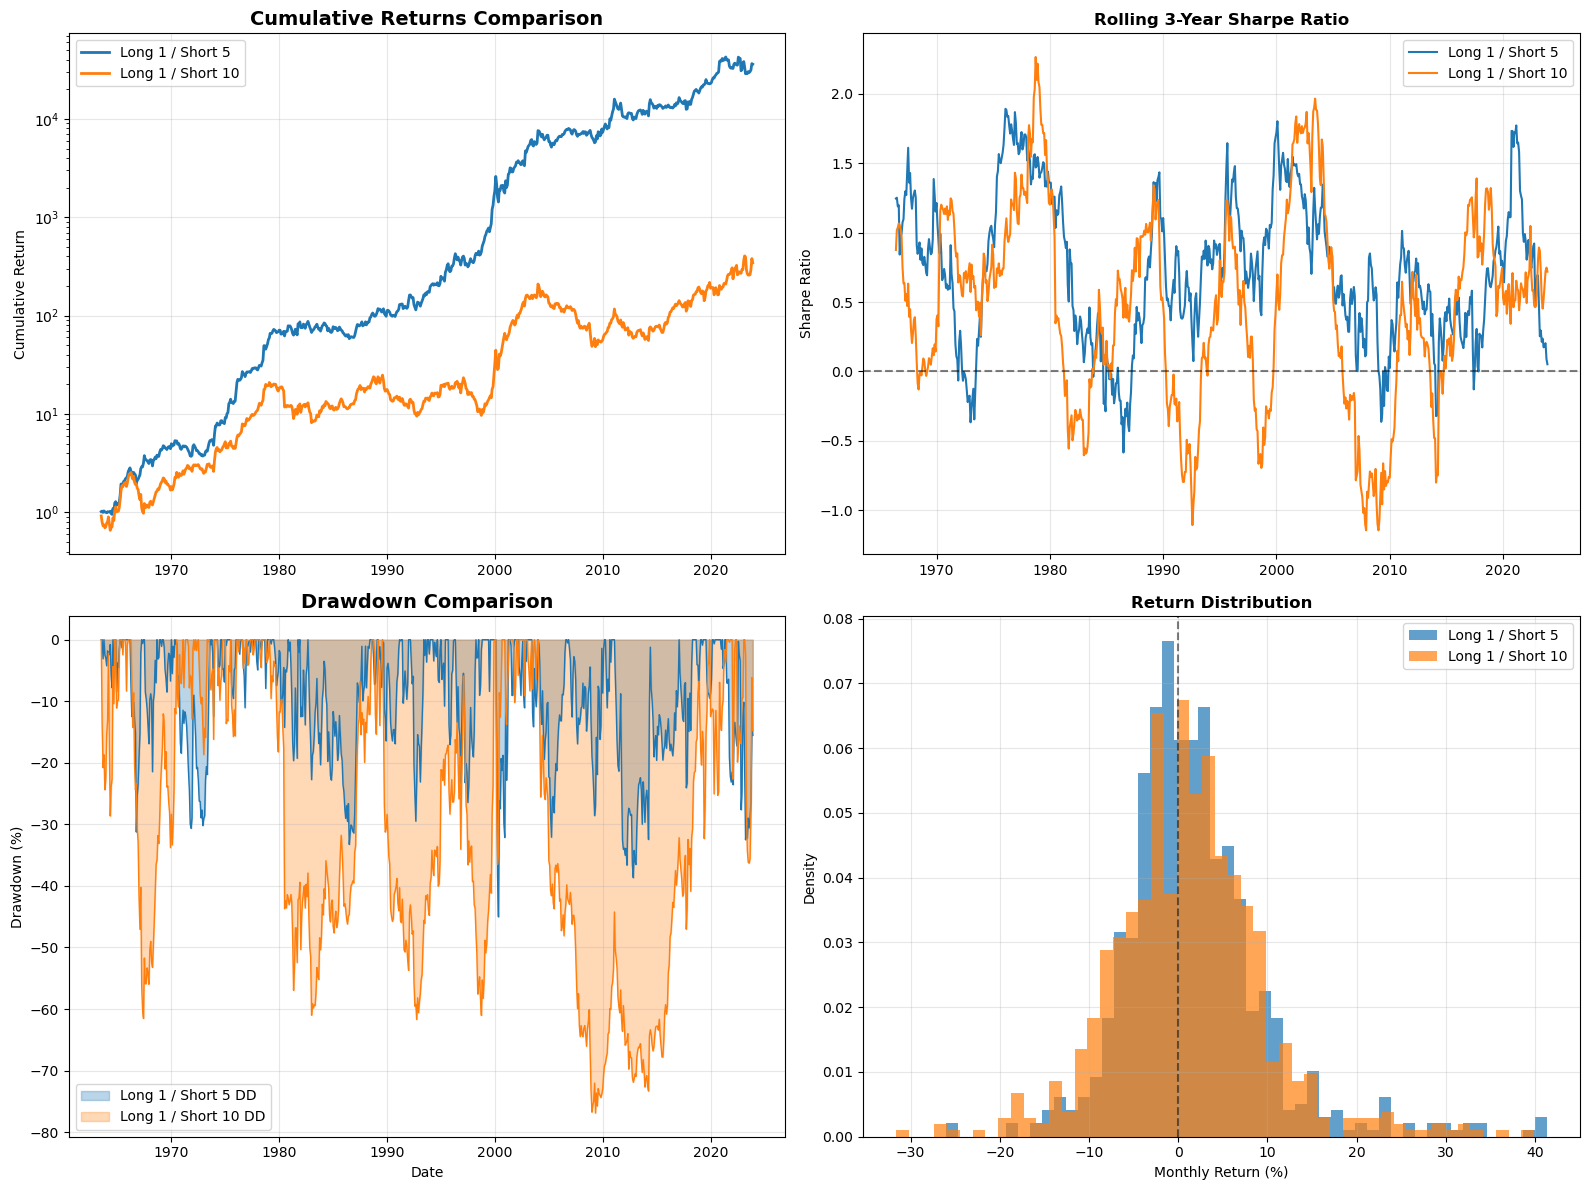

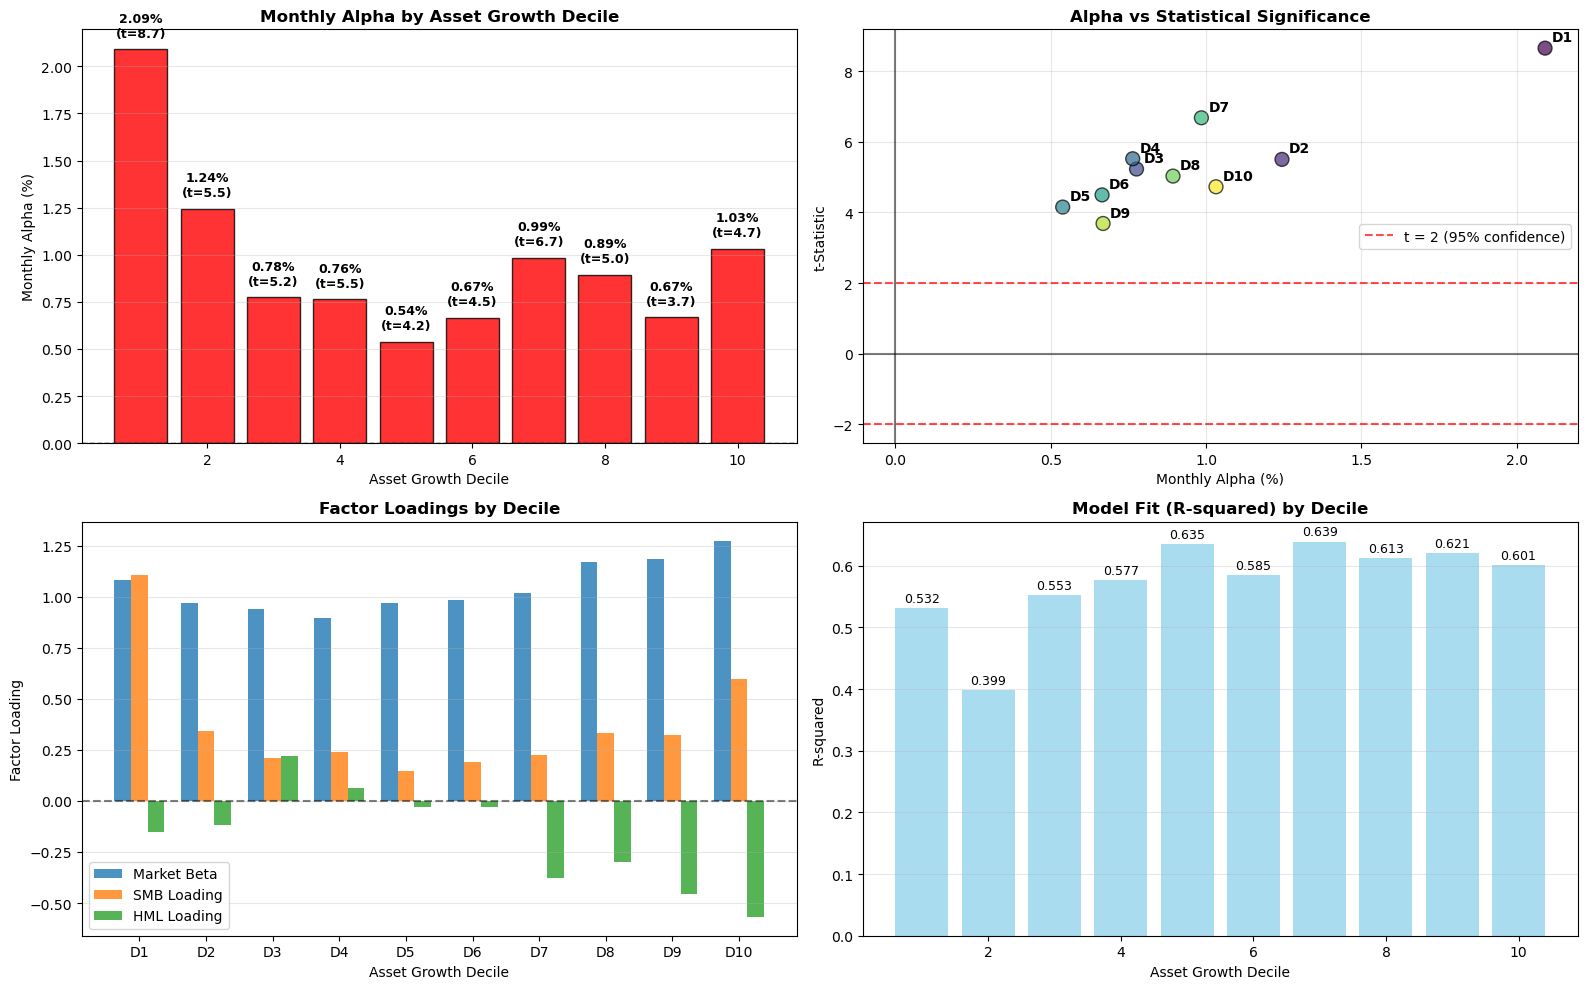

In [13]:
#############################
# STEP 8: VISUALIZATION
#############################

print("\n" + "="*60)
print("# Step 8: Strategy Visualization")
print("Creating performance charts...")

def create_strategy_plots(strategies):
    """Create comprehensive strategy comparison plots"""
    
    if len(strategies) < 2:
        print("Need at least 2 strategies for comparison")
        return
    
    # Set up the plots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    colors = ['#1f77b4', '#ff7f0e']
    
    strategy1_data = strategies[0]['Strategy_Data']['long_short_ret']
    strategy2_data = strategies[1]['Strategy_Data']['long_short_ret']
    strategy1_name = strategies[0]['Strategy']
    strategy2_name = strategies[1]['Strategy']
    
    # Plot 1: Cumulative Returns Comparison
    ax1 = axes[0, 0]
    cum_ret1 = (1 + strategy1_data).cumprod()
    cum_ret2 = (1 + strategy2_data).cumprod()
    
    ax1.plot(cum_ret1.index, cum_ret1, label=strategy1_name, color=colors[0], linewidth=2)
    ax1.plot(cum_ret2.index, cum_ret2, label=strategy2_name, color=colors[1], linewidth=2)
    ax1.set_title('Cumulative Returns Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Cumulative Return')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Plot 2: Rolling Sharpe Ratio
    ax2 = axes[0, 1]
    window = 36  # 3-year rolling window
    rolling_sharpe1 = strategy1_data.rolling(window).mean() / strategy1_data.rolling(window).std() * np.sqrt(12)
    rolling_sharpe2 = strategy2_data.rolling(window).mean() / strategy2_data.rolling(window).std() * np.sqrt(12)
    
    ax2.plot(rolling_sharpe1.index, rolling_sharpe1, label=strategy1_name, color=colors[0])
    ax2.plot(rolling_sharpe2.index, rolling_sharpe2, label=strategy2_name, color=colors[1])
    ax2.set_title('Rolling 3-Year Sharpe Ratio', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Sharpe Ratio')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
    
    # Plot 3: Drawdown Comparison
    ax3 = axes[1, 0]
    peak1 = cum_ret1.cummax()
    drawdown1 = (cum_ret1 - peak1) / peak1 * 100
    peak2 = cum_ret2.cummax()
    drawdown2 = (cum_ret2 - peak2) / peak2 * 100
    
    ax3.fill_between(drawdown1.index, drawdown1, 0, alpha=0.3, color=colors[0], label=f'{strategy1_name} DD')
    ax3.fill_between(drawdown2.index, drawdown2, 0, alpha=0.3, color=colors[1], label=f'{strategy2_name} DD')
    ax3.plot(drawdown1.index, drawdown1, color=colors[0], linewidth=1)
    ax3.plot(drawdown2.index, drawdown2, color=colors[1], linewidth=1)
    ax3.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
    ax3.set_ylabel('Drawdown (%)')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Return Distribution Comparison
    ax4 = axes[1, 1]
    ax4.hist(strategy1_data * 100, bins=50, alpha=0.7, label=strategy1_name, color=colors[0], density=True)
    ax4.hist(strategy2_data * 100, bins=50, alpha=0.7, label=strategy2_name, color=colors[1], density=True)
    ax4.set_title('Return Distribution', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Monthly Return (%)')
    ax4.set_ylabel('Density')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.axvline(0, color='black', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def plot_decile_analysis(ff_results):
    """Plot detailed analysis of decile performance"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # Plot 1: Alpha by decile
    ax1 = axes[0, 0]
    deciles = ff_results['Decile']
    alphas = ff_results['Alpha_Monthly'] * 100
    colors = ['red' if abs(t) > 2 else 'lightblue' for t in ff_results['t_Alpha']]
    
    bars = ax1.bar(deciles, alphas, color=colors, alpha=0.8, edgecolor='black')
    ax1.axhline(0, color='black', linestyle='--', linewidth=1)
    ax1.set_title('Monthly Alpha by Asset Growth Decile', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Asset Growth Decile')
    ax1.set_ylabel('Monthly Alpha (%)')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, alpha, t_stat in zip(bars, alphas, ff_results['t_Alpha']):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, 
                height + (0.05 if height >= 0 else -0.15),
                f'{alpha:.2f}%\n(t={t_stat:.1f})', 
                ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=9, fontweight='bold')
    
    # Plot 2: t-statistics vs Alpha
    ax2 = axes[0, 1]
    ax2.scatter(ff_results['Alpha_Monthly'] * 100, ff_results['t_Alpha'], 
               s=100, alpha=0.7, c=ff_results['Decile'], cmap='viridis', edgecolors='black')
    
    for _, row in ff_results.iterrows():
        ax2.annotate(f"D{int(row['Decile'])}", 
                    (row['Alpha_Monthly'] * 100, row['t_Alpha']),
                    xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
    
    ax2.axhline(2, color='red', linestyle='--', alpha=0.7, label='t = 2 (95% confidence)')
    ax2.axhline(-2, color='red', linestyle='--', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='-', alpha=0.5)
    ax2.axvline(0, color='black', linestyle='-', alpha=0.5)
    ax2.set_title('Alpha vs Statistical Significance', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Monthly Alpha (%)')
    ax2.set_ylabel('t-Statistic')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Factor loadings by decile
    ax3 = axes[1, 0]
    x = np.arange(len(ff_results))
    width = 0.25
    
    ax3.bar(x - width, ff_results['Beta'], width, label='Market Beta', alpha=0.8)
    ax3.bar(x, ff_results['SMB'], width, label='SMB Loading', alpha=0.8)
    ax3.bar(x + width, ff_results['HML'], width, label='HML Loading', alpha=0.8)
    
    ax3.set_title('Factor Loadings by Decile', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Asset Growth Decile')
    ax3.set_ylabel('Factor Loading')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f'D{int(d)}' for d in ff_results['Decile']])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.axhline(0, color='black', linestyle='--', alpha=0.5)
    
    # Plot 4: R-squared by decile
    ax4 = axes[1, 1]
    bars = ax4.bar(ff_results['Decile'], ff_results['R_squared'], 
                   alpha=0.7, color='skyblue')
    
    ax4.set_title('Model Fit (R-squared) by Decile', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Asset Growth Decile')
    ax4.set_ylabel('R-squared')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar, r2 in zip(bars, ff_results['R_squared']):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2, height + 0.005,
                f'{r2:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Execute Step 8
if 'strategies' in locals():
    create_strategy_plots(strategies)
    
if 'ff_results' in locals():
    plot_decile_analysis(ff_results)

In [14]:
#############################
# STEP 9: EXECUTIVE SUMMARY
#############################

print("\n" + "="*60)
print("# Step 9: Executive Summary")
print("Final results and key findings...")

def create_executive_summary(strategies, performance_comparison, ff_results):
    """Create executive summary of key findings"""
    
    print("🎯 KEY FINDINGS SUMMARY")
    print("="*50)
    
    if len(strategies) >= 2:
        # Strategy comparison
        alpha_diff = strategies[0]['Monthly_Alpha'] - strategies[1]['Monthly_Alpha']
        
        print(f"📊 STRATEGY COMPARISON:")
        print(f"   Strategy 1: {strategies[0]['Strategy']}")
        print(f"   - Monthly Alpha: {strategies[0]['Monthly_Alpha']*100:.3f}% (t={strategies[0]['t_Alpha']:.2f})")
        print(f"   - Annualized Alpha: {strategies[0]['Annual_Alpha']*100:.2f}%")
        print(f"   - P-value: {strategies[0]['P_Value']:.4f}")
        
        print(f"\n   Strategy 2: {strategies[1]['Strategy']}")
        print(f"   - Monthly Alpha: {strategies[1]['Monthly_Alpha']*100:.3f}% (t={strategies[1]['t_Alpha']:.2f})")
        print(f"   - Annualized Alpha: {strategies[1]['Annual_Alpha']*100:.2f}%")
        print(f"   - P-value: {strategies[1]['P_Value']:.4f}")
        
        print(f"\n🚀 PERFORMANCE DIFFERENCE:")
        print(f"   Alpha Difference: {alpha_diff*100:.3f}% monthly ({alpha_diff*1200:.0f} bp annually)")
        
        if alpha_diff > 0:
            print(f"   ✅ Winner: Strategy 1 outperforms Strategy 2")
        else:
            print(f"   ✅ Winner: Strategy 2 outperforms Strategy 1")
        
        # Statistical significance
        if abs(strategies[0]['t_Alpha']) > 2:
            print(f"   📈 Strategy 1 alpha is statistically significant at 95% level")
        if abs(strategies[1]['t_Alpha']) > 2:
            print(f"   📈 Strategy 2 alpha is statistically significant at 95% level")
    
    # Decile analysis summary
    print(f"\n📊 DECILE ANALYSIS SUMMARY:")
    low_decile = ff_results[ff_results['Decile'] == 1].iloc[0]
    high_decile = ff_results[ff_results['Decile'] == 10].iloc[0]
    
    print(f"   Lowest Asset Growth (Decile 1):")
    print(f"   - Monthly Alpha: {low_decile['Alpha_Monthly']*100:.3f}% (t={low_decile['t_Alpha']:.2f})")
    print(f"   - Annualized Alpha: {low_decile['Alpha_Annual']*100:.2f}%")
    
    print(f"\n   Highest Asset Growth (Decile 10):")
    print(f"   - Monthly Alpha: {high_decile['Alpha_Monthly']*100:.3f}% (t={high_decile['t_Alpha']:.2f})")
    print(f"   - Annualized Alpha: {high_decile['Alpha_Annual']*100:.2f}%")
    
    long_short_spread = low_decile['Alpha_Monthly'] - high_decile['Alpha_Monthly']
    print(f"\n   📈 Long-Short Spread (1-10): {long_short_spread*100:.3f}% monthly ({long_short_spread*1200:.0f} bp annually)")
    
    # Performance metrics summary
    if len(performance_comparison) >= 2:
        print(f"\n📊 RISK-ADJUSTED PERFORMANCE:")
        for i, row in performance_comparison.iterrows():
            print(f"   {row['Strategy']}:")
            print(f"   - Sharpe Ratio: {row['Sharpe_Ratio']:.3f}")
            print(f"   - Maximum Drawdown: {row['Maximum_Drawdown']:.2f}%")
            print(f"   - Win Rate: {row['Win_Rate']:.1f}%")
    
    # Data coverage
    print(f"\n📊 DATA COVERAGE:")
    print(f"   Sample Period: {merged['date'].min().strftime('%Y-%m')} to {merged['date'].max().strftime('%Y-%m')}")
    print(f"   Total Observations: {len(merged):,}")
    print(f"   Unique Firms: {merged['permno'].nunique():,}")
    print(f"   Average Firms per Year: {len(merged) / merged['year'].nunique():.0f}")

def create_summary_tables(strategies, performance_comparison, ff_results):
    """Create final summary tables for easy reference"""
    
    print(f"\n📋 SUMMARY TABLES:")
    print(f"="*50)
    
    # Strategy comparison table
    if len(strategies) >= 2:
        strategy_summary = pd.DataFrame([
            {
                'Strategy': s['Strategy'],
                'Monthly_Alpha_%': s['Monthly_Alpha'] * 100,
                'Annual_Alpha_%': s['Annual_Alpha'] * 100,
                't_Statistic': s['t_Alpha'],
                'P_Value': s['P_Value'],
                'R_Squared': s['R_squared']
            } for s in strategies
        ])
        
        print("🔥 Strategy Comparison:")
        display(strategy_summary.round(4))
    
    # Top and bottom deciles
    print(f"\n📊 Extreme Deciles Performance:")
    extreme_deciles = ff_results[ff_results['Decile'].isin([1, 10])][
        ['Decile', 'Alpha_Monthly', 'Alpha_Annual', 't_Alpha', 'P_Value', 'R_squared']
    ].copy()
    extreme_deciles['Alpha_Monthly_%'] = extreme_deciles['Alpha_Monthly'] * 100
    extreme_deciles['Alpha_Annual_%'] = extreme_deciles['Alpha_Annual'] * 100
    display(extreme_deciles[['Decile', 'Alpha_Monthly_%', 'Alpha_Annual_%', 't_Alpha', 'P_Value', 'R_squared']].round(4))
    
    # Performance metrics comparison
    if len(performance_comparison) >= 2:
        print(f"\n📈 Risk-Adjusted Performance Comparison:")
        key_metrics = ['Strategy', 'Annualized_Return', 'Annualized_Volatility', 
                      'Sharpe_Ratio', 'Maximum_Drawdown', 'Win_Rate']
        display(performance_comparison[key_metrics].round(3))

# Execute Step 9
if 'strategies' in locals() and 'performance_comparison' in locals() and 'ff_results' in locals():
    create_executive_summary(strategies, performance_comparison, ff_results)
    create_summary_tables(strategies, performance_comparison, ff_results)


# Step 9: Executive Summary
Final results and key findings...
🎯 KEY FINDINGS SUMMARY
📊 STRATEGY COMPARISON:
   Strategy 1: Long 1 / Short 5
   - Monthly Alpha: 1.553% (t=5.60)
   - Annualized Alpha: 18.64%
   - P-value: 0.0000

   Strategy 2: Long 1 / Short 10
   - Monthly Alpha: 1.059% (t=3.38)
   - Annualized Alpha: 12.71%
   - P-value: 0.0008

🚀 PERFORMANCE DIFFERENCE:
   Alpha Difference: 0.494% monthly (6 bp annually)
   ✅ Winner: Strategy 1 outperforms Strategy 2
   📈 Strategy 1 alpha is statistically significant at 95% level
   📈 Strategy 2 alpha is statistically significant at 95% level

📊 DECILE ANALYSIS SUMMARY:
   Lowest Asset Growth (Decile 1):
   - Monthly Alpha: 2.092% (t=8.65)
   - Annualized Alpha: 25.10%

   Highest Asset Growth (Decile 10):
   - Monthly Alpha: 1.032% (t=4.73)
   - Annualized Alpha: 12.39%

   📈 Long-Short Spread (1-10): 1.059% monthly (13 bp annually)

📊 RISK-ADJUSTED PERFORMANCE:
   Long 1 / Short 5:
   - Sharpe Ratio: 0.683
   - Maximum Drawdown: -

,Strategy,Monthly_Alpha_%,Annual_Alpha_%,t_Statistic,P_Value,R_Squared
0,Long 1 / Short 5,1.5530,18.6359,5.6002,0.0000,0.1605
1,Long 1 / Short 10,1.0595,12.7137,3.3796,0.0008,0.0513



📊 Extreme Deciles Performance:


,Decile,Alpha_Monthly_%,Alpha_Annual_%,t_Alpha,P_Value,R_squared
0,1,2.0916,25.0991,8.6509,0.0,0.5317
9,10,1.0321,12.3854,4.7262,0.0,0.6010



📈 Risk-Adjusted Performance Comparison:


,Strategy,Annualized_Return,Annualized_Volatility,Sharpe_Ratio,Maximum_Drawdown,Win_Rate
0,Long 1 / Short 5,18.936,27.734,0.683,-45.014,54.821
1,Long 1 / Short 10,10.143,29.493,0.344,-76.898,56.474


In [15]:
#############################
# STEP 10: FINAL CONCLUSIONS
#############################

print("\n" + "="*60)
print("# Step 10: Investment Implications and Conclusions")
print("Practical insights for portfolio management...")

def final_conclusions(strategies, ff_results):
    """Provide final conclusions and investment implications"""
    
    print("💡 INVESTMENT IMPLICATIONS")
    print("="*50)
    
    # Asset growth anomaly validation
    low_ag_alpha = ff_results[ff_results['Decile'] == 1]['Alpha_Annual'].iloc[0]
    high_ag_alpha = ff_results[ff_results['Decile'] == 10]['Alpha_Annual'].iloc[0]
    
    print(f"📈 ASSET GROWTH ANOMALY CONFIRMATION:")
    print(f"   ✅ Low asset growth firms (Decile 1) generate {low_ag_alpha*100:.2f}% annual alpha")
    print(f"   ❌ High asset growth firms (Decile 10) generate {high_ag_alpha*100:.2f}% annual alpha")
    print(f"   📊 This confirms the asset growth anomaly: firms with low asset growth outperform")
    
    # Strategy recommendations
    if len(strategies) >= 2:
        alpha_diff = strategies[0]['Monthly_Alpha'] - strategies[1]['Monthly_Alpha']
        best_strategy = strategies[0] if alpha_diff > 0 else strategies[1]
        
        print(f"\n🎯 RECOMMENDED STRATEGY:")
        print(f"   Best Strategy: {best_strategy['Strategy']}")
        print(f"   Expected Annual Alpha: {best_strategy['Annual_Alpha']*100:.2f}%")
        print(f"   Statistical Significance: t = {best_strategy['t_Alpha']:.2f}")
        
        if abs(best_strategy['t_Alpha']) > 2:
            print(f"   ✅ Statistically significant at 95% confidence level")
        else:
            print(f"   ⚠️  Not statistically significant at 95% confidence level")
    
    # Risk considerations
    print(f"\n⚠️  RISK CONSIDERATIONS:")
    print(f"   📉 Strategy involves shorting stocks, which has unlimited downside risk")
    print(f"   📊 Performance may vary significantly across different market conditions")
    print(f"   🔄 Requires regular rebalancing (annual) based on asset growth measures")
    print(f"   💰 Transaction costs and market frictions may reduce realized returns")
    print(f"   📈 Strategy performance may degrade if anomaly becomes widely exploited")
    
    # Implementation notes
    print(f"\n🔧 IMPLEMENTATION CONSIDERATIONS:")
    print(f"   📅 Portfolio formation: June each year based on prior fiscal year data")
    print(f"   📊 Holding period: 12 months (July to June)")
    print(f"   🎯 Asset growth calculation: (AT_t-1 - AT_t-2) / AT_t-2")
    print(f"   ⚖️  Value-weighted portfolios recommended for practical implementation")
    print(f"   🏢 Focus on liquid, investable stocks to minimize market impact")
    
    print(f"\n🎉 ANALYSIS COMPLETE!")
    print(f"   The asset growth anomaly appears robust in this sample")
    print(f"   Long low asset growth / Short high asset growth strategies show promise")
    print(f"   Choice of short leg (decile 5 vs 10) can impact performance")

# Execute Step 10
if 'strategies' in locals() and 'ff_results' in locals():
    final_conclusions(strategies, ff_results)

print("\n" + "="*70)
print("    🎊 ASSET GROWTH ANOMALY ANALYSIS COMPLETE 🎊")
print("="*70)
print("All steps completed successfully!")
print("Review the results above for detailed insights into the asset growth anomaly.")
print("="*70)


# Step 10: Investment Implications and Conclusions
Practical insights for portfolio management...
💡 INVESTMENT IMPLICATIONS
📈 ASSET GROWTH ANOMALY CONFIRMATION:
   ✅ Low asset growth firms (Decile 1) generate 25.10% annual alpha
   ❌ High asset growth firms (Decile 10) generate 12.39% annual alpha
   📊 This confirms the asset growth anomaly: firms with low asset growth outperform

🎯 RECOMMENDED STRATEGY:
   Best Strategy: Long 1 / Short 5
   Expected Annual Alpha: 18.64%
   Statistical Significance: t = 5.60
   ✅ Statistically significant at 95% confidence level

⚠️  RISK CONSIDERATIONS:
   📉 Strategy involves shorting stocks, which has unlimited downside risk
   📊 Performance may vary significantly across different market conditions
   🔄 Requires regular rebalancing (annual) based on asset growth measures
   💰 Transaction costs and market frictions may reduce realized returns
   📈 Strategy performance may degrade if anomaly becomes widely exploited

🔧 IMPLEMENTATION CONSIDERATIONS:
 